In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# switch to the project directory
%cd ..
# working directory should be ../pdi

/home/mytkom/Documents/alice/pdi


In [3]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

#### How to use this notebook?
1. Train models with desired configs and use `scripts` subdirectory scripts to achieve that.
2. Fill `MODELS` dictionary with paths to the results dir of the run and name it appropriately as in dictionary element key.
3. Run desired plot/table generation cells. 

In [4]:
from pdi.constants import PART_NAME_TO_TARGET_CODE

MODELS = {
    "Attention": "results/attention_hyperparameter_tuning/kaon/run_23",
}
target_code = PART_NAME_TO_TARGET_CODE["kaon"]

save_dir = "reports"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
import json
from pdi.config import Config
from pdi.engines import build_engine
from pdi.results_and_metrics import TestResults
from pdi.data.data_preparation import DataPreparation
from pdi.data.types import Split

data_prep: DataPreparation = None
checksums = set()
test_results: dict[str, TestResults] = {}
for k, v in MODELS.items():
    with open(f"{v}/config.json", 'r') as f:
        config_data = json.load(f)
    config = Config.from_dict(config_data)
    config.training.device = "cpu"
    engine = build_engine(config, target_code, base_dir=v)
    current_data_prep = engine.get_data_prep()
    if data_prep is None:
        data_prep = current_data_prep
    checksums.add(current_data_prep._inputs_checksum)
    test_results[k] = engine.test(model_dirpath=v)

if len(checksums) > 1:
    raise RuntimeError("You shouldn't compare models trained on different datasets.")

test_results["nSigma < 1.0"] = data_prep.get_nsigma_test_results(target_code, threshold_unscaled=1.0)


[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: 9725cd4537fa1d48492d5d6407da6181
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.


#### Extract Unwrapped and Unstandardized Test Split Data as a DataFrame
The test split data is explicitly obtained from the `CombinedDataLoader` to ensure consistency. Only the `CombinedDataLoader` has the knowledge of how to unwrap itself, and it will raise errors if the operation cannot be performed. While this could also be achieved by adding an additional method in the `DataPreparation` class, doing so would require `DataPreparation` to understand the internal structure of the `CombinedDataLoader`. This approach would also necessitate updates to `DataPreparation` whenever changes are made to the `CombinedDataLoader`. Therefore, the current approach is preferred for maintaining separation of concerns and avoiding unnecessary dependencies. It is also thousands times faster than iterating over and over dataloader and concatenating batches.

In [6]:
test_dl = data_prep.create_dataloaders(
    {
        Split.TEST: 1 # not used
    },
    {
        Split.TEST: 1 # not used
    },
    False, False)[0]

test_data_unwrapped = test_dl.unwrap()
print(test_data_unwrapped.shape)
test_data_unwrapped.head()

(596000, 29)


,targets,gids,fTPCSignal,fTRDPattern,fTOFSignal,fBeta,fP,fPx,fPy,fPz,...,fTPCNSigmaMu,fTPCNSigmaPi,fTPCNSigmaKa,fTPCNSigmaPr,fTOFNSigmaEl,fTOFNSigmaMu,fTOFNSigmaPi,fTOFNSigmaKa,fTOFNSigmaPr,fPt
0,-211.0,36863,51.500977,NaN,NaN,NaN,0.227241,-0.146025,-0.135375,-0.109494,...,-0.349672,-1.944770,-11.657392,-13.473336,-999.0,-999.0,-999.0,-999.0,-999.0,0.199122
1,211.0,36863,54.603516,NaN,NaN,NaN,0.647695,-0.490844,0.002452,0.422581,...,1.141570,1.520577,-2.831595,-8.770067,-999.0,-999.0,-999.0,-999.0,-999.0,0.490850
2,211.0,36863,71.236328,NaN,NaN,NaN,0.155745,-0.024551,0.151098,0.028689,...,1.478907,-1.883781,-12.527679,-13.761636,-999.0,-999.0,-999.0,-999.0,-999.0,0.153079
3,211.0,36863,49.084961,NaN,NaN,NaN,0.313898,0.307811,0.056784,0.023664,...,-0.115301,-0.805332,-9.988670,-12.855588,-999.0,-999.0,-999.0,-999.0,-999.0,0.313005
4,211.0,36863,54.888672,NaN,NaN,NaN,0.494158,-0.395007,0.007579,0.296823,...,1.593957,1.721864,-5.341982,-10.642926,-999.0,-999.0,-999.0,-999.0,-999.0,0.395080


#### Generate comparison table on optimal posterior probability threshold for f1

In [7]:
import pandas as pd

metrics_data = []
for model_name, test_result in test_results.items():
    metrics = test_result.test_metrics.to_dict()
    metrics['Model'] = model_name
    metrics_data.append(metrics)

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Save as LaTeX table
latex_table = metrics_df.to_latex(index=False)
with open(f"{save_dir}/test_metrics_comparison_{target_code}.tex", "w") as f:
    f.write(latex_table)

# Save as CSV file
metrics_df.to_csv(f"{save_dir}/test_metrics_comparison_{target_code}.csv", index=False)

print("LaTeX table and CSV file saved successfully.")

         f1  precision    recall      loss  threshold  target_code  \
0  0.303658   0.202508  0.606690  0.108488   0.126741          321   
1  0.439780   0.289233  0.917169       NaN   0.500001          321   
2  0.452810   0.328302  0.729454       NaN   0.666668          321   
3  0.349735   0.331754  0.369777       NaN   0.833334          321   

          Model  
0     Attention  
1  nSigma < 3.0  
2  nSigma < 2.0  
3  nSigma < 1.0  
LaTeX table and CSV file saved successfully.


/tmp/ipykernel_1948932/1038849264.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics_df.to_latex(index=False)


#### Precision-recall curve for changing posterior probability threshold

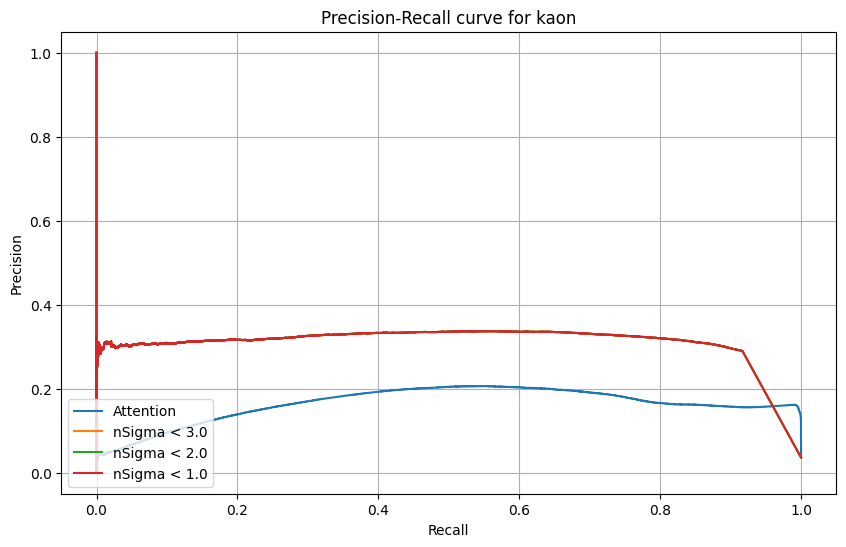

<Figure size 640x480 with 0 Axes>

In [8]:
from pdi.visualise import plot_precision_recall_comparison

plot_precision_recall_comparison(test_results, save_dir=save_dir)

#### Evaluation metrics vs transverse momentum for optimal posterior probability threshold for f1


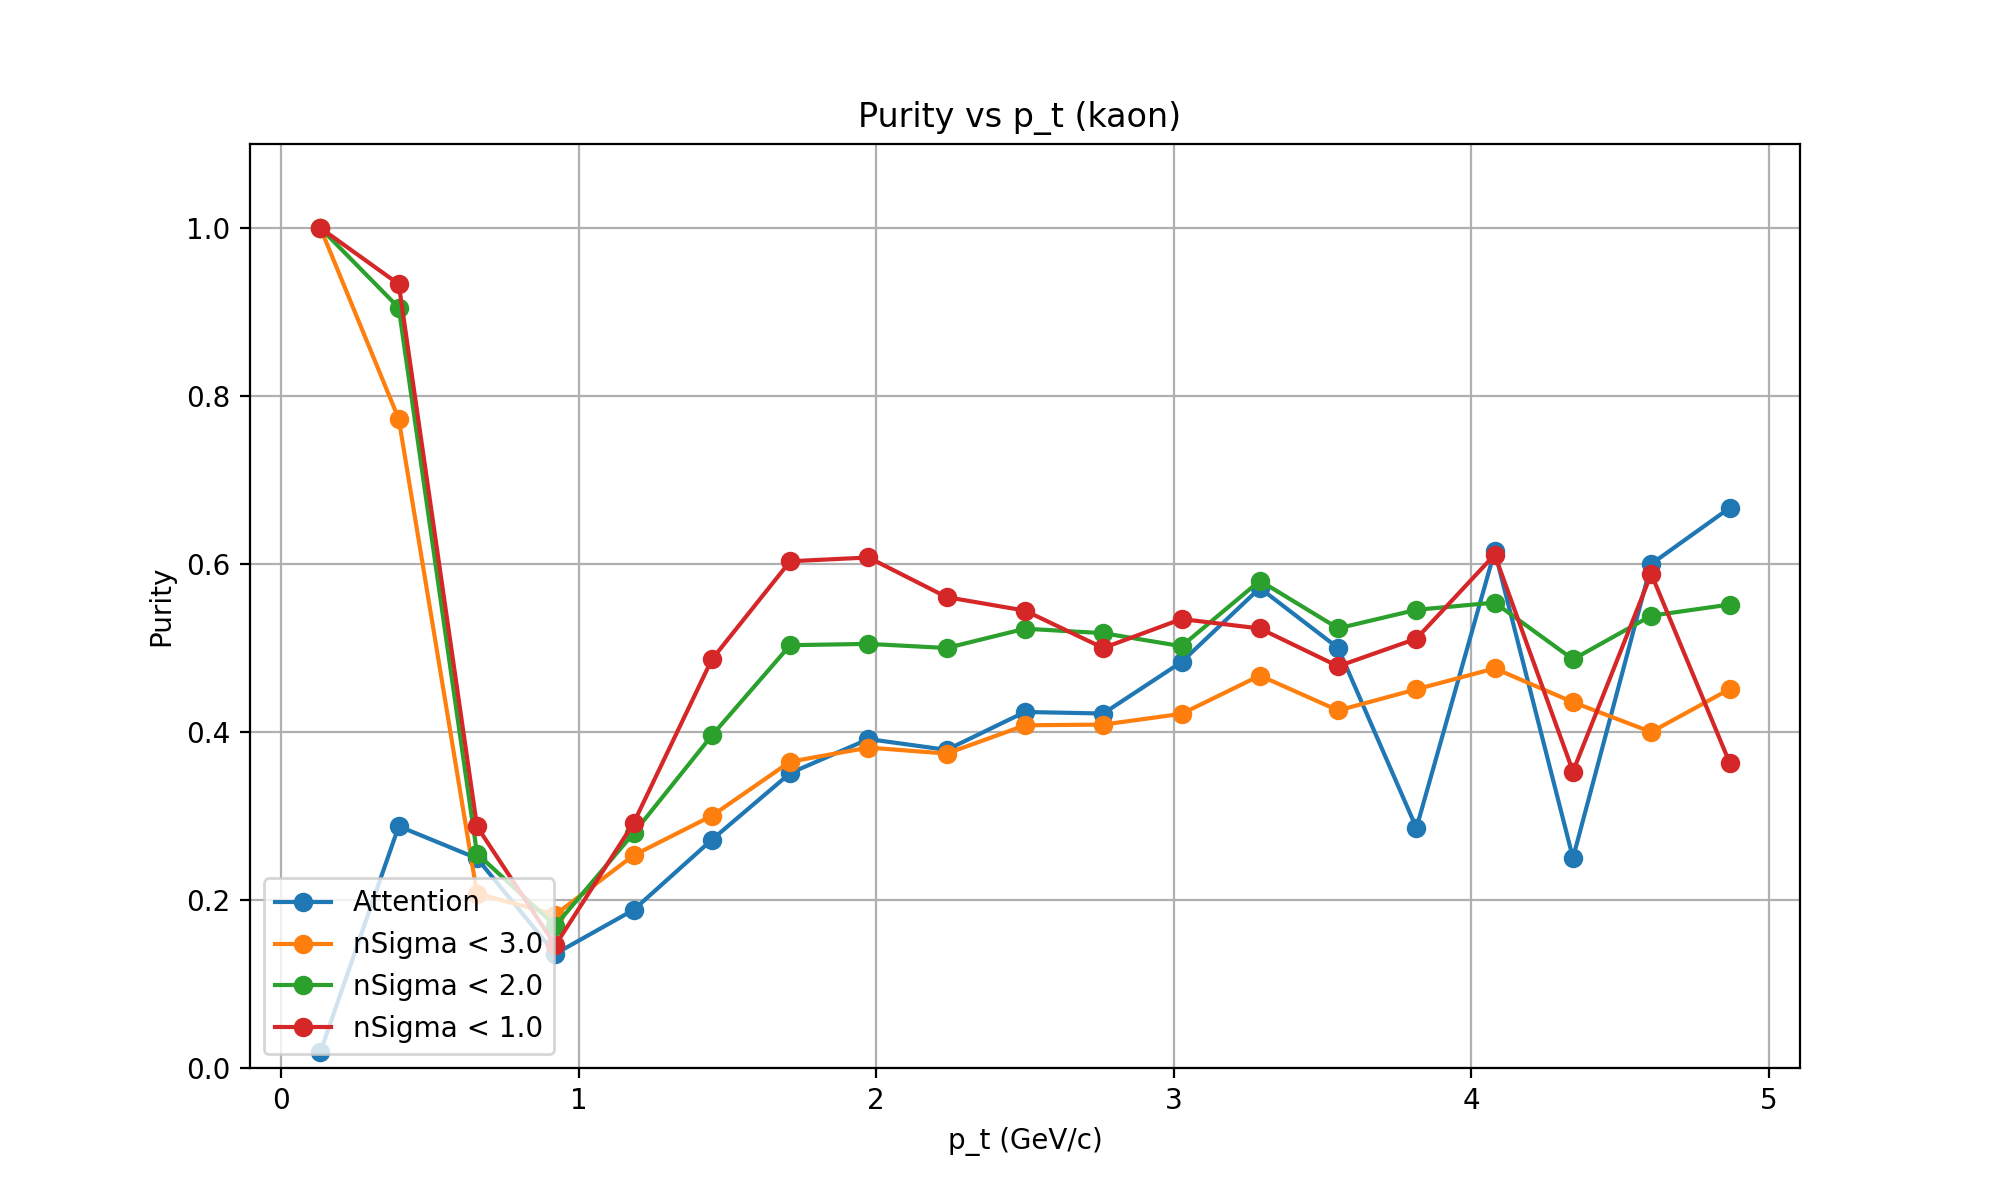
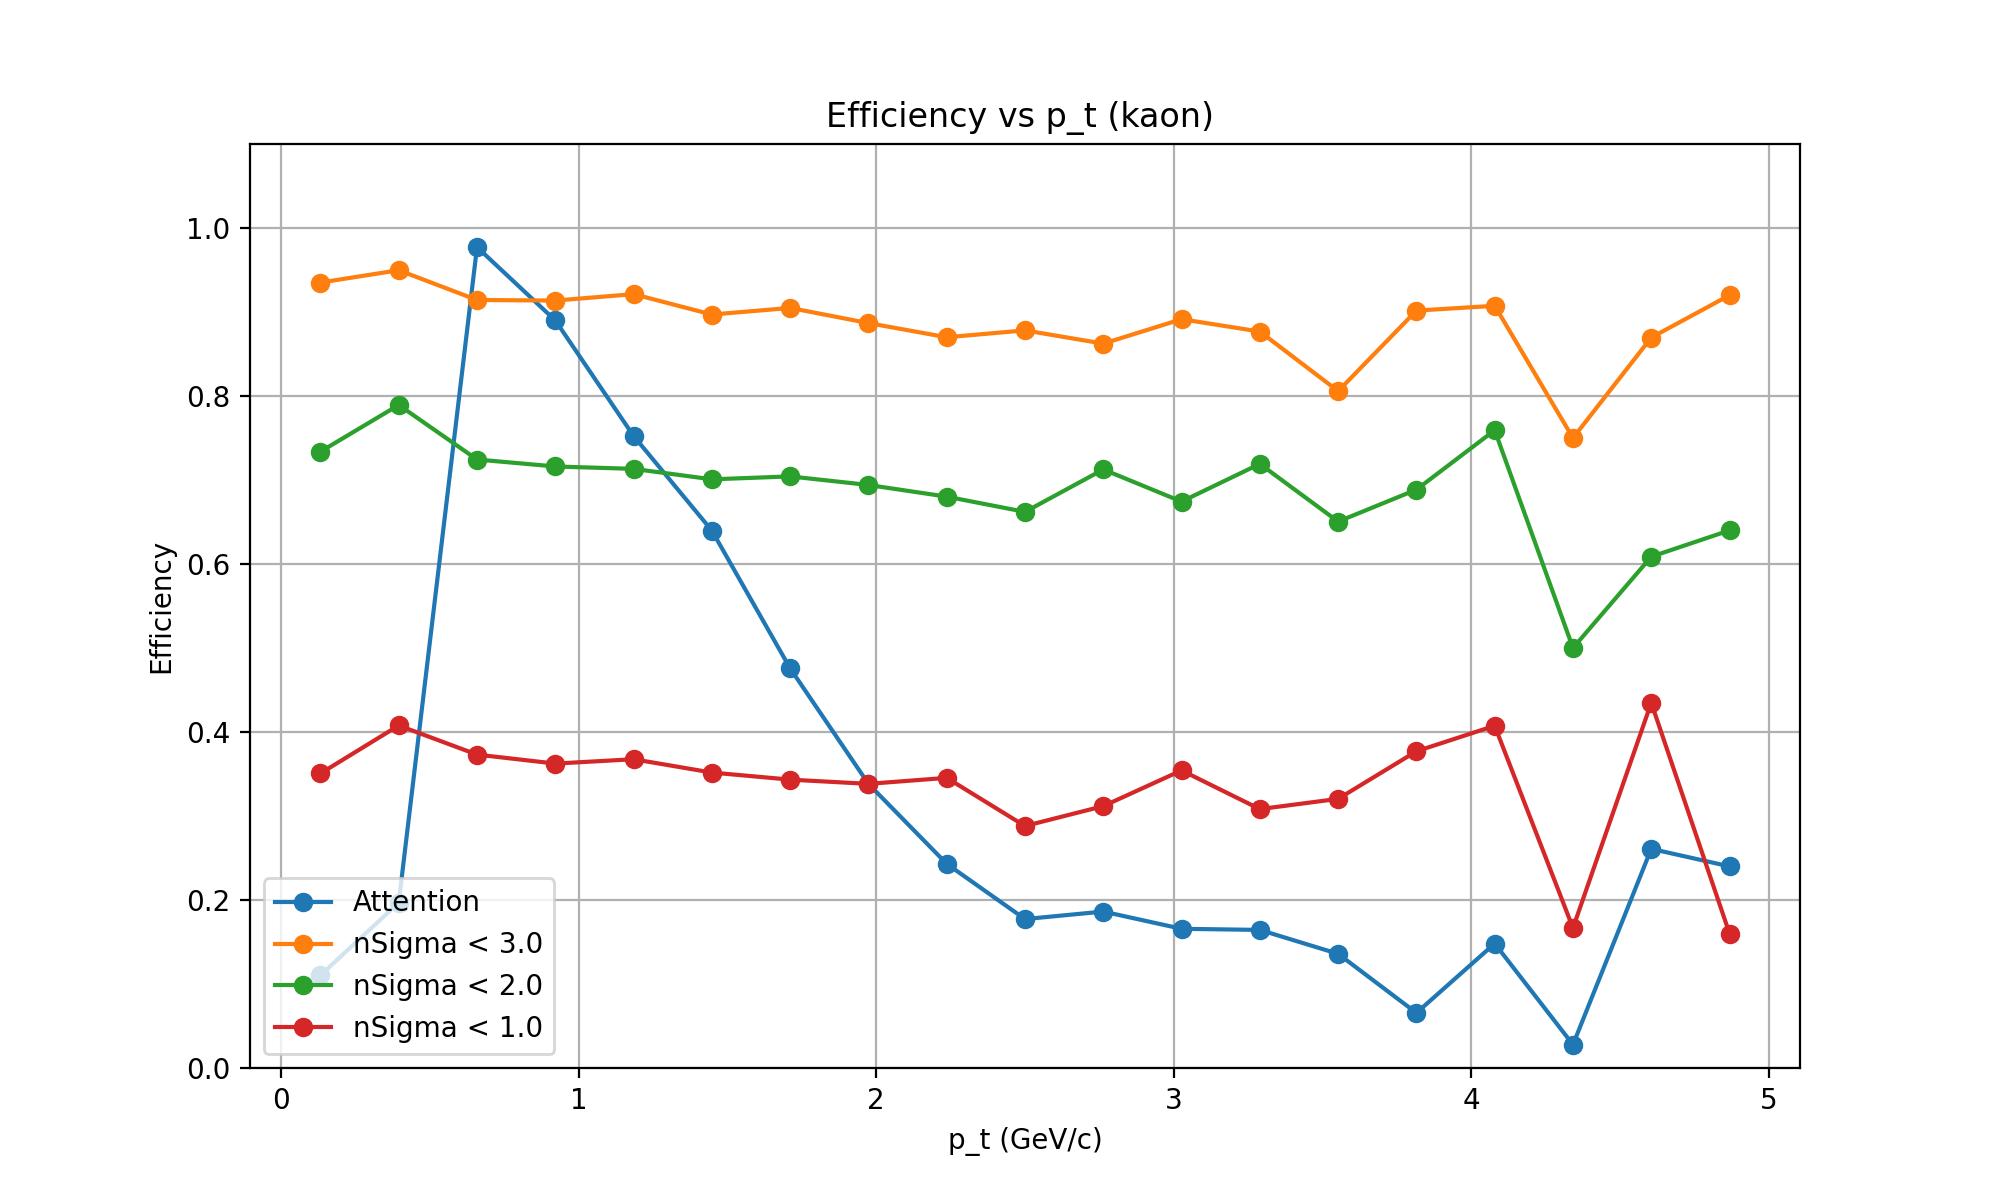
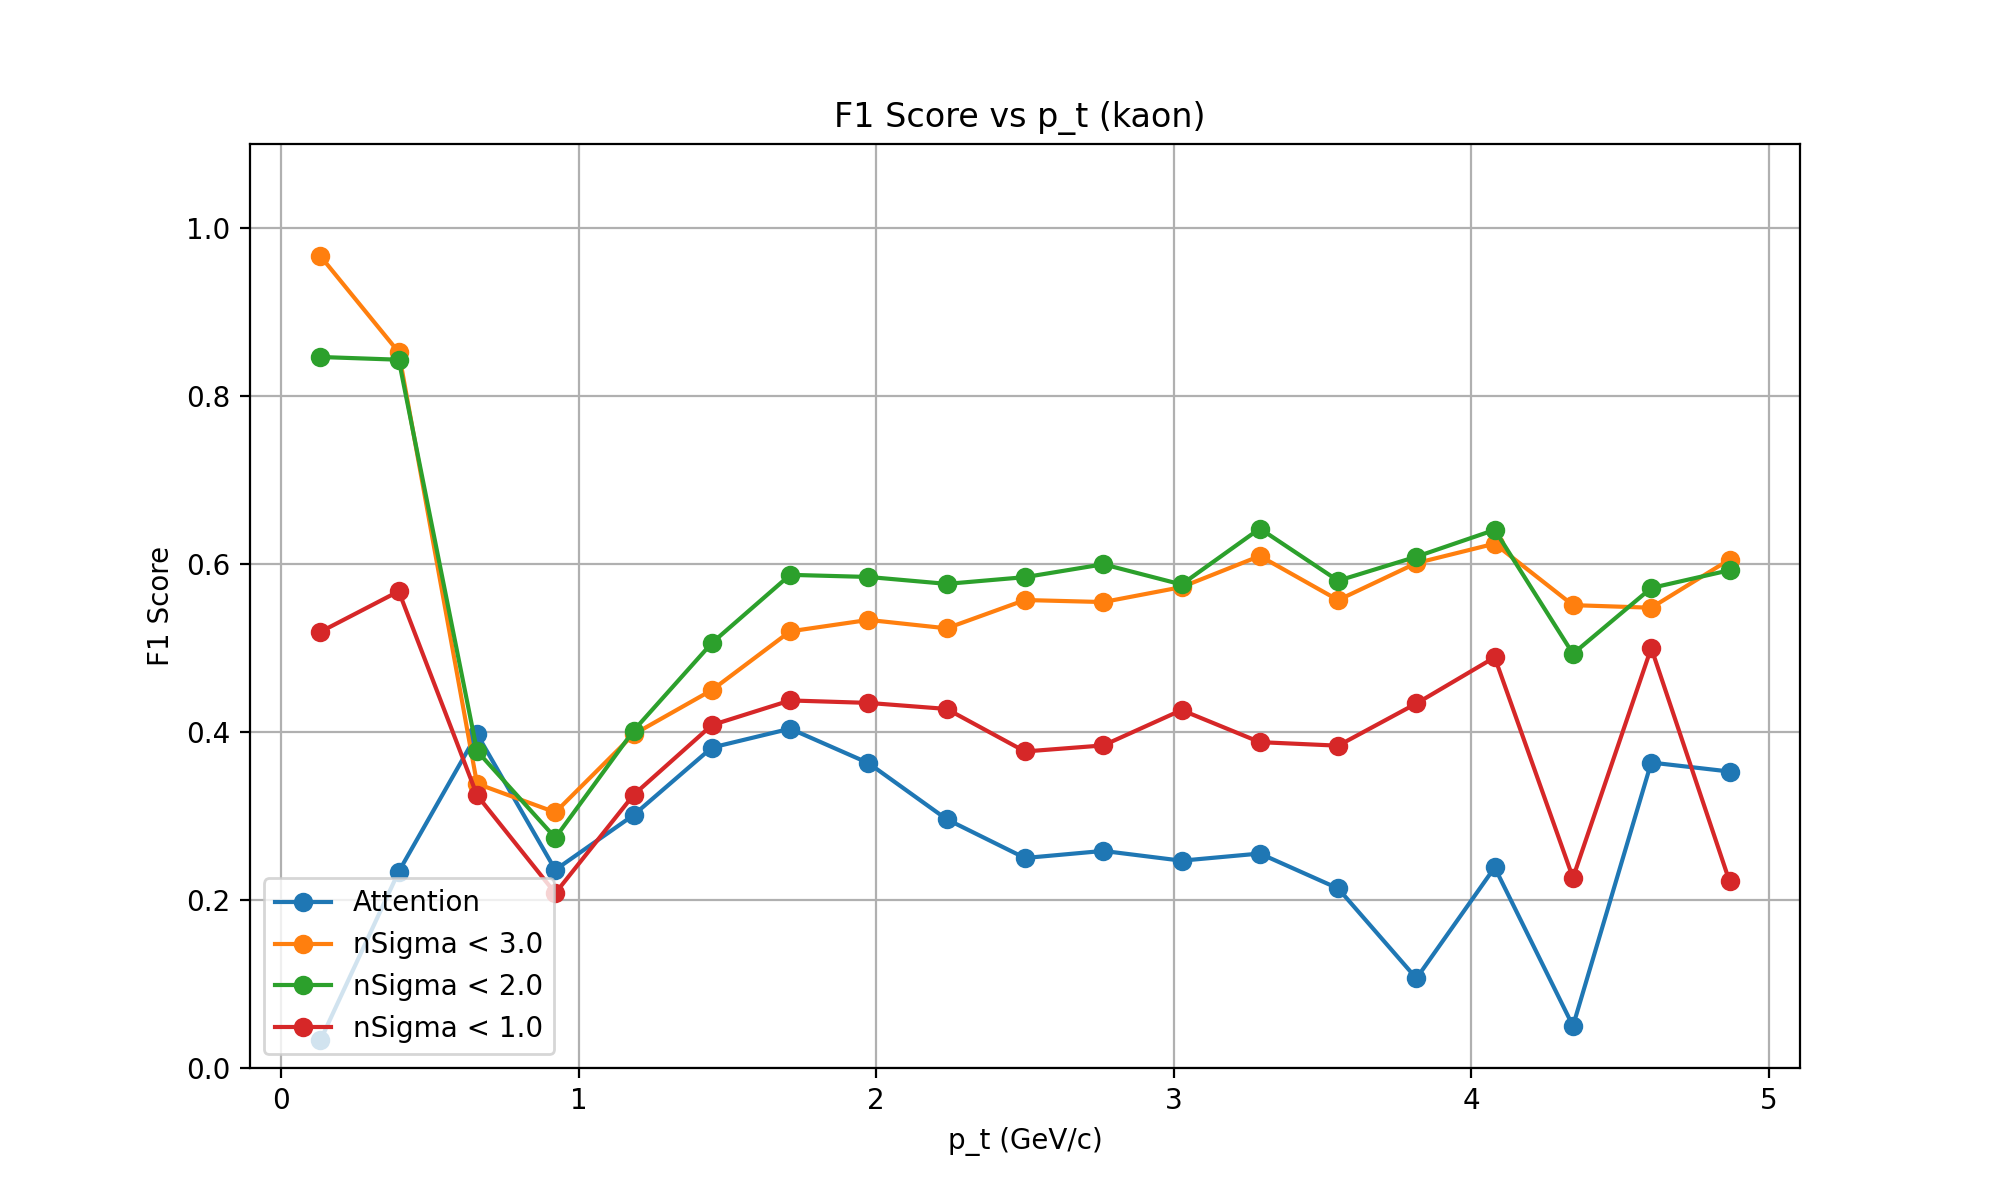

In [9]:
from pdi.visualise import plot_metrics_vs_pt_comparison
from pdi.data.data_exploration import generate_figure_thumbnails_from_iterator

generate_figure_thumbnails_from_iterator(plot_metrics_vs_pt_comparison(test_results, pt=test_data_unwrapped["fPt"].to_numpy(), save_dir=save_dir), save_path=save_dir, thumbnail_width=600)